# Baseball Playoff Prediction

In [164]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean, col, when, isnull, count, create_map, lit, isnan
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix

## EDA

In [72]:
# Create Spark Session
spark = SparkSession.builder.appName('BaseballPred').getOrCreate()
baseballdata = spark.read.csv('../Data/baseball.csv', header=True, inferSchema=True)

In [73]:
baseballdata.printSchema()

root
 |-- Team: string (nullable = true)
 |-- League: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- RS: integer (nullable = true)
 |-- RA: integer (nullable = true)
 |-- W: integer (nullable = true)
 |-- OBP: double (nullable = true)
 |-- SLG: double (nullable = true)
 |-- BA: double (nullable = true)
 |-- Playoffs: integer (nullable = true)
 |-- RankSeason: integer (nullable = true)
 |-- RankPlayoffs: integer (nullable = true)
 |-- G: integer (nullable = true)
 |-- OOBP: double (nullable = true)
 |-- OSLG: double (nullable = true)



In [74]:
baseballdata.show(5)

+----+------+----+---+---+---+-----+-----+-----+--------+----------+------------+---+-----+-----+
|Team|League|Year| RS| RA|  W|  OBP|  SLG|   BA|Playoffs|RankSeason|RankPlayoffs|  G| OOBP| OSLG|
+----+------+----+---+---+---+-----+-----+-----+--------+----------+------------+---+-----+-----+
| ARI|    NL|2012|734|688| 81|0.328|0.418|0.259|       0|      null|        null|162|0.317|0.415|
| ATL|    NL|2012|700|600| 94| 0.32|0.389|0.247|       1|         4|           5|162|0.306|0.378|
| BAL|    AL|2012|712|705| 93|0.311|0.417|0.247|       1|         5|           4|162|0.315|0.403|
| BOS|    AL|2012|734|806| 69|0.315|0.415| 0.26|       0|      null|        null|162|0.331|0.428|
| CHC|    NL|2012|613|759| 61|0.302|0.378| 0.24|       0|      null|        null|162|0.335|0.424|
+----+------+----+---+---+---+-----+-----+-----+--------+----------+------------+---+-----+-----+
only showing top 5 rows



In [75]:
# Number of rows and columns
print(baseballdata.count())
print(len(baseballdata.columns))

1232
15


In [76]:
# Let's see how many distinct values there are in RankPlayoffs
baseballdata.select('RankPlayoffs').distinct().count()

6

In [77]:
baseballdata.filter(baseballdata.RankSeason.isNull()).count()

988

In [78]:
baseballdata.select('G').distinct().show()

+---+
|  G|
+---+
|159|
|164|
|163|
|165|
|161|
|162|
|160|
|158|
+---+



Since we want to predict what takes a team to make it to the playoffs based on their regular season results, we will remove RankPlayoffs as that is the result of a team making it to the playoffs and that does not contribute to our prediction. We also will remove RankSeason as a majority of the data is null, thus not improving the model. As a note, since the data was up to 2012, there were 5 teams each AL and NL in the playoffs. Thus, that gives us the distinct count of 6 since teams could be ranked 1 through 5 and the rest would be null if they didn't make it to the playoffs.

MLB season consists of 162 regular season games, which doesn't include Spring Training, the All-Star Game, and the postseason. They can play fewer games if a game is rained out and cannot be made up. Teams may play more games if two teams are tied for a playoff spot.

In [79]:
# asterisk unpacks the list -- (*['RankSeason', 'RankPlayoffs'] --> ('RankSeason', 'RankPlayoffs'))
col_to_drop = ['RankSeason', 'RankPlayoffs']
baseballdata = baseballdata.drop(*col_to_drop)

In [80]:
baseballdata.show()

+----+------+----+---+---+---+-----+-----+-----+--------+---+-----+-----+
|Team|League|Year| RS| RA|  W|  OBP|  SLG|   BA|Playoffs|  G| OOBP| OSLG|
+----+------+----+---+---+---+-----+-----+-----+--------+---+-----+-----+
| ARI|    NL|2012|734|688| 81|0.328|0.418|0.259|       0|162|0.317|0.415|
| ATL|    NL|2012|700|600| 94| 0.32|0.389|0.247|       1|162|0.306|0.378|
| BAL|    AL|2012|712|705| 93|0.311|0.417|0.247|       1|162|0.315|0.403|
| BOS|    AL|2012|734|806| 69|0.315|0.415| 0.26|       0|162|0.331|0.428|
| CHC|    NL|2012|613|759| 61|0.302|0.378| 0.24|       0|162|0.335|0.424|
| CHW|    AL|2012|748|676| 85|0.318|0.422|0.255|       0|162|0.319|0.405|
| CIN|    NL|2012|669|588| 97|0.315|0.411|0.251|       1|162|0.305| 0.39|
| CLE|    AL|2012|667|845| 68|0.324|0.381|0.251|       0|162|0.336| 0.43|
| COL|    NL|2012|758|890| 64| 0.33|0.436|0.274|       0|162|0.357| 0.47|
| DET|    AL|2012|726|670| 88|0.335|0.422|0.268|       1|162|0.314|0.402|
| HOU|    NL|2012|583|794| 55|0.302|0.

In [81]:
baseballdata.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in baseballdata.columns]).show()

+----+------+----+---+---+---+---+---+---+--------+---+----+----+
|Team|League|Year| RS| RA|  W|OBP|SLG| BA|Playoffs|  G|OOBP|OSLG|
+----+------+----+---+---+---+---+---+---+--------+---+----+----+
|   0|     0|   0|  0|  0|  0|  0|  0|  0|       0|  0| 812| 812|
+----+------+----+---+---+---+---+---+---+--------+---+----+----+



In [82]:
baseballdata.select('OOBP').summary().show()

+-------+-------------------+
|summary|               OOBP|
+-------+-------------------+
|  count|                420|
|   mean|0.33226428571428523|
| stddev| 0.0152953160413899|
|    min|              0.294|
|    25%|              0.321|
|    50%|              0.331|
|    75%|              0.343|
|    max|              0.384|
+-------+-------------------+



In [83]:
baseballdata.select('OSLG').summary().show()

+-------+--------------------+
|summary|                OSLG|
+-------+--------------------+
|  count|                 420|
|   mean| 0.41974285714285714|
| stddev|0.026509611377709855|
|    min|               0.346|
|    25%|               0.401|
|    50%|               0.419|
|    75%|               0.438|
|    max|               0.499|
+-------+--------------------+



In [84]:
baseballdata.filter(baseballdata.OOBP.isNull()).select('Year').distinct().show(n=40)

+----+
|Year|
+----+
|1990|
|1975|
|1977|
|1974|
|1978|
|1997|
|1988|
|1968|
|1973|
|1979|
|1971|
|1966|
|1991|
|1967|
|1969|
|1982|
|1996|
|1989|
|1998|
|1963|
|1965|
|1985|
|1970|
|1987|
|1980|
|1992|
|1983|
|1984|
|1964|
|1986|
|1976|
|1962|
|1993|
+----+



In [85]:
baseballdata.filter(baseballdata.Year == 1999).show()

+----+------+----+----+----+---+-----+-----+-----+--------+---+-----+-----+
|Team|League|Year|  RS|  RA|  W|  OBP|  SLG|   BA|Playoffs|  G| OOBP| OSLG|
+----+------+----+----+----+---+-----+-----+-----+--------+---+-----+-----+
| ANA|    AL|1999| 711| 826| 70|0.322|0.395|0.256|       0|162|0.346|0.427|
| ARI|    NL|1999| 908| 676|100|0.347|0.459|0.277|       1|162| 0.32|0.402|
| ATL|    NL|1999| 840| 661|103|0.341|0.436|0.266|       1|162|0.314|0.377|
| BAL|    AL|1999| 851| 815| 78|0.353|0.447|0.279|       0|162| 0.35|0.441|
| BOS|    AL|1999| 836| 718| 94| 0.35|0.448|0.278|       1|162|0.315|0.398|
| CHC|    NL|1999| 747| 920| 67|0.329| 0.42|0.257|       0|162|0.346|0.467|
| CHW|    AL|1999| 777| 870| 75|0.337|0.429|0.277|       0|162|0.353|0.447|
| CIN|    NL|1999| 865| 711| 96|0.341|0.451|0.272|       0|163|0.324|0.411|
| CLE|    AL|1999|1009| 860| 97|0.373|0.467|0.289|       1|162|0.347|0.439|
| COL|    NL|1999| 906|1028| 72|0.348|0.472|0.288|       0|162|0.384|0.499|
| DET|    AL

In years 1972, 1981, 1994, and 1995, there is no baseball data as there were player strikes during these years. Furthermore, prior to the 1999 season, there is no data on OOBP and OSLG, as they most likely did not have the technology to keep track of these data. Since baseball has also changed with technology, and OOBP and OSLG are important measurements to a team's performance, I will include data from 1999 to 2012.

In [86]:
baseballdata = baseballdata.filter(baseballdata.Year >= 1999)

In [87]:
baseballdata.count()

420

In [176]:
# Converting to pandas df
bb_df = baseballdata.toPandas()

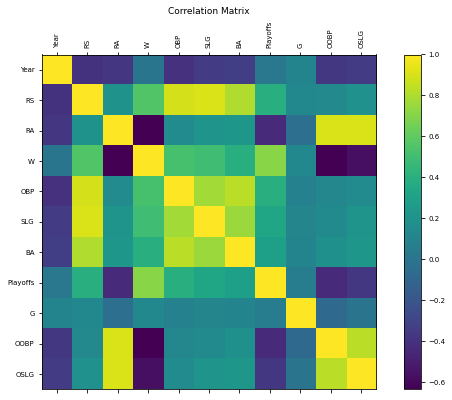

In [124]:
# Correlation Matrix
cor = bb_df.corr()
f = plt.figure(figsize=(10,6))
plt.matshow(cor, fignum=f.number)
plt.xticks(range(len(cor.columns)), cor.columns, fontsize=7, rotation = 90)
plt.yticks(range(len(cor.columns)), cor.columns, fontsize=7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=7)
plt.title("Correlation Matrix", fontsize = 9)
plt.show()

It is important to note that there are predictors that are highly correlated to each other due to the fact that many of these calculations stem from similar metrics. Multicollinearity can lead to predictions being overfitted on a certain set of features, which can impact the signficance of another variable that could have more predicting power. We will handle this situation in the feature engineering portion.

## Feature Engineering

In [ ]:
# Win percentage
# Encoding for Year, League, Team
# Class imbalance
# OBP + SLG = OPS same with OOBP and OSLG -- can drop the original columns after

In [177]:
def clean_data(df):
    df['OPS'] = df['OBP'] + df['SLG']
    df['OOPS'] = df['OOBP'] + df['OSLG']
    df['W_PCT'] = df['W']/df['G']

    # One hot encoding
    onehotencoder = OneHotEncoder()
    onehotencoder_df = pd.DataFrame(onehotencoder.fit_transform(df[['Team', 'League']]).toarray())
    onehotencoder_df.columns = onehotencoder.get_feature_names_out(['Team', 'League'])
    ordencoder = OrdinalEncoder()
    ordencoder_df = pd.DataFrame(ordencoder.fit_transform(df[['Year']]))
    df = df.join(onehotencoder_df)
    df['Year'] = ordencoder_df
    df = df.drop(columns=['OBP', 'SLG', 'OOBP','OSLG','W', 'G','Team', 'League'])
    return df

In [178]:
bb_df = clean_data(bb_df)

In [179]:
bb_df

,Year,RS,RA,BA,Playoffs,OPS,OOPS,W_PCT,Team_ANA,Team_ARI,Team_ATL,Team_BAL,Team_BOS,Team_CHC,Team_CHW,Team_CIN,Team_CLE,Team_COL,Team_DET,Team_FLA,Team_HOU,Team_KCR,Team_LAA,Team_LAD,Team_MIA,Team_MIL,Team_MIN,Team_MON,Team_NYM,Team_NYY,Team_OAK,Team_PHI,Team_PIT,Team_SDP,Team_SEA,Team_SFG,Team_STL,Team_TBD,Team_TBR,Team_TEX,Team_TOR,Team_WSN,League_AL,League_NL
0,13.0,734,688,0.259,0,0.746,0.732,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,13.0,700,600,0.247,1,0.709,0.684,0.580247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,13.0,712,705,0.247,1,0.728,0.718,0.574074,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,13.0,734,806,0.260,0,0.730,0.759,0.425926,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,13.0,613,759,0.240,0,0.680,0.759,0.376543,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,872,831,0.271,0,0.790,0.768,0.530864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416,0.0,809,838,0.262,0,0.764,0.782,0.465839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
417,0.0,772,913,0.274,0,0.754,0.819,0.425926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
418,0.0,945,859,0.293,1,0.840,0.805,0.586420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [180]:
X = bb_df.drop(['Playoffs'], axis=1)
y = bb_df['Playoffs']

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('X training data: ', X_train.shape, '; ', 'y training data: ', y_train.shape,'; ', 'X testing data: ', X_test.shape,'; ', 'y testing data: ', y_test.shape)

X training data:  (336, 43) ;  y training data:  (336,) ;  X testing data:  (84, 43) ;  y testing data:  (84,)


In [182]:
# Class imbalance
bb_df['Playoffs'].value_counts()

0    306
1    114
Name: Playoffs, dtype: int64

In [184]:
# Rebalancing only training data to avoid artificially boosted model scores
counter = Counter(y_train)
print('Before', counter)
over = SMOTE(sampling_strategy=0.5) # oversample minority class to have 50 percent the number of ex of majority class
under = RandomUnderSampler(sampling_strategy=0.5) # reduce the number of examples majority class to have 60 percent more than the minority class
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('After', counter)

Before Counter({0: 247, 1: 89})
After Counter({0: 246, 1: 123})


In [185]:
model = Sequential()
model.add(Dense(44, input_shape=(43,), activation = 'relu'))
model.add(Dense(23, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 44)                1936      
                                                                 
 dense_9 (Dense)             (None, 23)                1035      
                                                                 
 dense_10 (Dense)            (None, 1)                 24        
                                                                 
Total params: 2,995
Trainable params: 2,995
Non-trainable params: 0
_________________________________________________________________


In [186]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/10
12/12 [==============================] - 1s 23ms/step - loss: 10.0359 - accuracy: 0.5745 - val_loss: 1.7405 - val_accuracy: 0.7024
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 1.8770 - accuracy: 0.6016 - val_loss: 0.3068 - val_accuracy: 0.8452
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6377 - accuracy: 0.7940 - val_loss: 0.3914 - val_accuracy: 0.8810
Epoch 4/10
12/12 [==============================] - 0s 4ms/step - loss: 0.8011 - accuracy: 0.7967 - val_loss: 0.3626 - val_accuracy: 0.8929
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6016 - accuracy: 0.8374 - val_loss: 0.4029 - val_accuracy: 0.8929
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.4971 - accuracy: 0.8537 - val_loss: 0.3236 - val_accuracy: 0.8810
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.4821 - accuracy: 0.8537 - val_loss: 0.3204 - val_accuracy: 0.8810


In [187]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.3626 - accuracy: 0.8929


[0.3626396954059601, 0.8928571343421936]